# Week VI - The Ising model (Part I)

Today, we will discuss a possible implementation of the **2D Ising model on a square lattice**. In particular, we will consider a system in equilibrium with a thermal bath, such that the temperature is constant. Temporal evolution will be simulated through the **spin flip dynamics** in periodic boundary conditions (PBC).

We will study the model by monitoring the following quantities:
* spin magnetisation 
    $$\frac{M}{N}  = \frac{1}{N}\sum_i s_i$$
* energy 
    $$\frac{E}{N} = \frac{1}{N}\sum_{NN(i,j)} s_i$$
* heat capacity
    $$c = \frac{<E^2>-<E>^2}{k_BT^2N}$$
* magnetic susceptibility
    $$\chi = \frac{<M^2>-<M>^2}{k_BTN}$$

In the following we will set $k_B=1$ and $J=1$.

In [222]:
import numpy as np
import matplotlib.pyplot as plt

class Ising:
    '''
    This class implements 
    the 2D Ising model
    on a square lattice in PBCs
    '''
    
    def __init__(self,L,T,N_equi,N_mcs,sample_equi=False,bc='obc',data_filename='data.txt'):
        'Initialise the Ising model'
        self.L = L
        self.N = L**2
        self.T = T
        self.M = None
        self.M_N = None
        self.E = None
        self.E_N = None
        self.E_N_av = None
        self.M_N_av = None
        self.rng = np.random.default_rng(seed=42424)
        self.spin = np.zeros((L,L),dtype=np.int32)
        self.w_dict = {}
        self.acc = 0
        self.counter = 0
        self.N_equi = N_equi
        self.N_mcs = N_mcs
        self.data = []
        self.ar = None
        self.var = None
        self.sample_equi = sample_equi
        self.c_heat = None
        self.chi_mag = None
        self.autocorr = []
        self.n_autocorr = 10
        self.data_filename = data_filename 
        self.bc = bc
    
    def make_pm(self,x):
        '''
        Convert random uniform array
        into array of -1 and +1
        '''
        def tmp(x):
            if x<0.5:
                return 1
            else:
                return -1
        f = np.frompyfunc(tmp, 1, 1)
        return f(x)
    
    def get_up_right(self, i, j, bc):
        '''
        PBCs up/right
        '''
        if bc == 'pbc':
            if j == (self.L - 1):
                up = 0
            else:
                up = j + 1
            if i == (self.L - 1):
                right = 0
            else:
                right = i + 1
        elif bc == 'obc':
            if j == (self.L - 1):
                up = j
            else:
                up = j + 1
            if i == (self.L - 1):
                right = i
            else:
                right = i + 1

        return up, right
    
    def get_down_left(self, i, j, bc):
        '''
        PBCs down/left
        '''
        if bc == 'pbc':
            if j == 0:
                down = self.L - 1
            else:
                down = j - 1
            if i == 0:
                left = self.L - 1
            else:
                left = i - 1
        elif bc == 'obc':
            if j == 0:
                down = j
            else:
                down = j - 1
            if i == 0:
                left = i
            else:
                left = i - 1

        return down, left
    
    def calc_energy(self):
        '''
        Calculates the total energy.
        NB: this is used only at initialization.
        '''
        E = 0
        for j in range(self.L):
            for i in range(self.L):
                up, right = self.get_up_right(i, j, self.bc)
                if self.bc == 'obc' and (up == j or right == i):
                    E = E - self.spin[i, j] * 0
                else:
                    E = E - self.spin[i, j] * (self.spin[i, up] + self.spin[right, j])
        return E
    
    def deltaE(self, i, j):
        '''
        Calculates change in energy for the spin flip
        '''
        up, right = self.get_up_right(i, j, self.bc)
        down, left = self.get_down_left(i, j, self.bc)

        if self.bc == 'obc':
            up_val = 0 if up == j else self.spin[i, up]
            down_val = 0 if down == j else self.spin[i, down]
            left_val = 0 if left == i else self.spin[left, j]
            right_val = 0 if right == i else self.spin[right, j]
            res = 2.0 * self.spin[i,j] * (up_val + down_val + left_val + right_val)
        else:
            res = 2.0 *self.spin[i,j] * (self.spin[i,up] +self.spin[i,down] +self.spin[left,j] +self.spin[right,j])

        return (res,int(res))

    
    def initialize(self):
        '''
        Initialization of the system:
        -spins are randomly configured
        -energy is calculated from scratch
        -dictionary with Metropolis' probability
        coefficents is created
        '''
        r = self.rng.random((self.L,self.L))
        self.spin = self.make_pm(r)
        self.M = np.sum(self.spin)
        self.M_N = self.M/float(self.N)
        self.E = self.calc_energy()
        self.E_N = self.E/float(self.N)
        for dE in range(-8,8+1,2):
            self.w_dict[dE] = np.exp(-1.0*dE/self.T)
    
    def metro_step(self):
        'One step of Metropolis spin flip dynamics'
        for ispin in range(self.N):
            (ii,jj) =self.rng.integers(0,high=self.L,size=2)
            dE,dE_int=self.deltaE(ii,jj)
            rnd_w=self.rng.random()
            if (rnd_w<=self.w_dict[dE_int]):
                self.spin[ii,jj]=-1*self.spin[ii,jj]
                self.acc+=1
                self.M=self.M+2*self.spin[ii,jj]
                self.M_N=self.M/float(self.N)
                self.E=self.E+dE
                self.E_N=self.E/float(self.N)


    def metro_driver(self,N_step,store=True):
        'Run N Metropolis steps of spin flip dynamics'
        for i in range(N_step):
            self.counter += self.N
            self.metro_step()
            if store:
                self.data.append((self.E,self.M))          
            
    def ising_driver(self):
        '''
        Main driver for the Monte Carlo
        '''
        self.initialize()
        self.metro_driver(self.N_equi,store=self.sample_equi)
        self.metro_driver(self.N_mcs)
        self.data = np.array(self.data)
        np.savetxt(self.data_filename,self.data)
    
    @staticmethod
    def plot_spin(spin):
        x,y = np.meshgrid(range(spin.shape[0]),range(spin.shape[1]))
        plt.xlabel('x')
        plt.ylabel('y')
        plt.scatter(x,y,c=spin[x,y],label='spin')
        plt.title('spin configuration')
        plt.colorbar()
        plt.savefig(savepath + "Spin.pdf", dpi=300, bbox_inches="tight")
        plt.show()
    
    @staticmethod
    def calc_autocorr(a,N):
        'Autocorrelation function'
        res = np.ones(N)
        for k in range(1,N):
            c_k = np.average(a[:-k]*a[k:]) 
            x_r = np.average(a[:-k])
            x_r_2 = np.average(a[:-k]**2)
            res[k] = (c_k-x_r**2)/(x_r_2-x_r**2)
        return res
    
    def get_stats(self):
        '''
        Calculate, store and print 
        statistical quantities
        '''
        self.ar = self.acc*1.0/self.counter
        self.E_N_av =np.average(self.data[:,0])/self.N
        self.M_N_av = np.average(self.data[:,1])/self.N
        self.c_heat = (np.average(self.data[:,0]**2)- (self.E_N_av*self.N)**2)/(self.T**2*self.N)
        self.chi_mag = (np.average(self.data[:,1]**2)- (self.M_N_av*self.N)**2)/(self.T**2*self.N)
        print("Total number of steps run = {}".format(self.counter/self.N))
        print("Acceptance ratio = {}".format(self.ar))
        print("Temperature = {}".format(self.T))
        print("<E/N> = {}".format(self.E_N_av))
        print("<M/N> = {}".format(self.M_N_av))
        print("<E/N>^2 = {}".format((self.E_N_av)**2))
        print("<M/N>^2 = {}".format((self.M_N_av)**2))
        print("specific heat = {}".format(self.c_heat))
        print("magnetic susceptibility = {}".format(self.chi_mag))

> Let's run the code!

In [267]:
# lateral size L (N=LxL), temperature T, nequil, nmcas
T_c = 2.269
ising = Ising(4,2,0,2000,sample_equi=True,bc='obc')
ising.initialize()

In [268]:
#array with current spin configuration
ising.spin.shape

(4, 4)

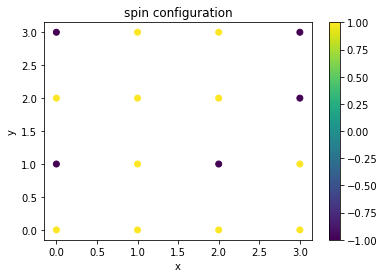

In [269]:
ising.plot_spin(ising.spin)

In [270]:
#Running Monte Carlo
ising.ising_driver()
#Extracting key quantities
ising.get_stats()

Total number of steps run = 2000.0
Acceptance ratio = 0.29428125
Temperature = 2
<E/N> = -0.8131875
<M/N> = -0.21125
<E/N>^2 = 0.6612739101562499
<M/N>^2 = 0.044626562499999994
specific heat = 0.5952481093750004
magnetic susceptibility = 1.7572437500000002


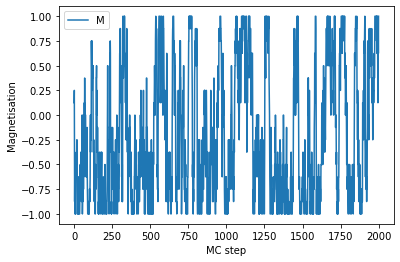

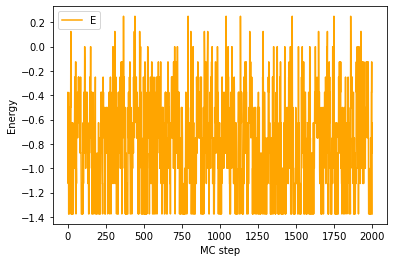

In [271]:
savepath = "C:/Nicola/universita/Data_science/Labfisicacomputazionale/Assignment2/"

plt.ylabel('Magnetisation')
plt.xlabel('MC step')
#plt.plot(np.abs(ising.data[:,1] / ising.N),'-',label='|M|')
plt.plot(ising.data[:,1] / ising.N,'-',label='M')
plt.legend()
plt.savefig(savepath + "Magnetization_obc.pdf", dpi=300, bbox_inches="tight")
plt.show()
plt.close()

plt.ylabel('Energy')
plt.xlabel('MC step')
plt.plot(ising.data[:,0] / ising.N,'-',label='E',c='orange')
plt.legend()
plt.savefig(savepath + "Energy_obc.pdf", dpi=300, bbox_inches="tight")
plt.show()

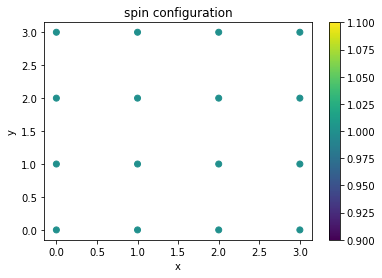

In [272]:
ising.plot_spin(ising.spin)

-----------------------------------

Now we increase the temperature to T=4.

Total number of steps run = 2000.0
Acceptance ratio = 0.6120633333333333
Temperature = 4
<E/N> = -0.53954
<M/N> = -0.004866666666666667
<E/N>^2 = 0.29110341160000003
<M/N>^2 = 2.3684444444444445e-05
specific heat = 0.15580337527777577
magnetic susceptibility = 0.26969608333333334


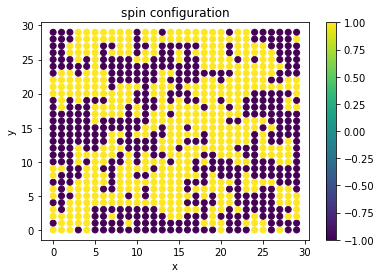

In [251]:
# lateral size L (N=LxL), temperature T, nequil, nmcas
ising = Ising(30,4,1000,1000,sample_equi=True,bc='obc')
ising.initialize()
ising.ising_driver()
ising.get_stats()
ising.plot_spin(ising.spin)

-------------------------

>There seems to be a phase transition between T=2 and T=4, let's investigate what happens as a function of temperature.

In [280]:
res=[]
#T_list = [0.5*i for i in range(3,9)]
T_list = np.linspace(1.5,4,26)
for T in T_list:
    ising = Ising(4,T,1000,1000,sample_equi=False,bc='obc')
    ising.initialize()
    ising.ising_driver()
    ising.get_stats()
    res.append((ising.E_N_av,ising.M_N_av,ising.c_heat,ising.chi_mag))
res = np.array(res)

Total number of steps run = 2000.0
Acceptance ratio = 0.12709375
Temperature = 1.5
<E/N> = -1.14725
<M/N> = -0.075875
<E/N>^2 = 1.3161825625000003
<M/N>^2 = 0.0057570156249999995
specific heat = 0.5898128888888863
magnetic susceptibility = 5.533172333333334
Total number of steps run = 2000.0
Acceptance ratio = 0.15959375
Temperature = 1.6
<E/N> = -1.0865
<M/N> = -0.19575
<E/N>^2 = 1.18048225
<M/N>^2 = 0.0383180625
specific heat = 0.6130015624999997
magnetic susceptibility = 4.259535546874999
Total number of steps run = 2000.0
Acceptance ratio = 0.18346875
Temperature = 1.7
<E/N> = -1.02875
<M/N> = 0.027375
<E/N>^2 = 1.0583265625
<M/N>^2 = 0.000749390625
specific heat = 0.6205103806228379
magnetic susceptibility = 3.7578753460207612
Total number of steps run = 2000.0
Acceptance ratio = 0.22259375
Temperature = 1.8
<E/N> = -0.956875
<M/N> = 0.119875
<E/N>^2 = 0.9156097656250001
<M/N>^2 = 0.014370015625
specific heat = 0.6399672067901231
magnetic susceptibility = 2.955348688271605
Total n

[[-1.14725000e+00 -7.58750000e-02  5.89812889e-01  5.53317233e+00]
 [-1.08650000e+00 -1.95750000e-01  6.13001562e-01  4.25953555e+00]
 [-1.02875000e+00  2.73750000e-02  6.20510381e-01  3.75787535e+00]
 [-9.56875000e-01  1.19875000e-01  6.39967207e-01  2.95534869e+00]
 [-8.96250000e-01 -4.97500000e-02  6.29716066e-01  2.46105235e+00]
 [-8.40000000e-01 -1.20125000e-01  6.09350000e-01  1.99534244e+00]
 [-7.84125000e-01  1.82500000e-01  5.65786338e-01  1.58925170e+00]
 [-7.42500000e-01  1.12000000e-01  5.06322314e-01  1.41751983e+00]
 [-6.75750000e-01  4.00000000e-03  4.45045558e-01  1.17036749e+00]
 [-6.69875000e-01  7.03750000e-02  4.07296832e-01  1.04731037e+00]
 [-6.21250000e-01 -5.17500000e-02  4.06284000e-01  9.06264160e-01]
 [-5.83375000e-01 -1.45625000e-01  3.46305880e-01  7.22624815e-01]
 [-5.40875000e-01  1.12500000e-02  3.00962654e-01  6.42246228e-01]
 [-5.26750000e-01  1.00000000e-02  2.81575383e-01  5.82385204e-01]
 [-4.91875000e-01 -1.17500000e-02  2.66194263e-01  4.94802735e

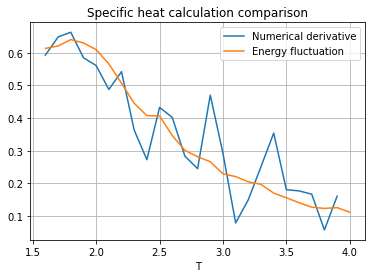

In [281]:
res = np.array(res)
print(res)

dEdT = []
for i in range(1, len(res)-1):
    der = (res[i+1,0] - res[i-1,0]) / (T_list[i+1] - T_list[i-1])
    dEdT.append(der)
    
#for i in range(len(dEdT)):
#    print(np.around(T_list[i+1],3), np.around(dEdT[i],3), np.around(res[i+1,2],3), np.around(abs(dEdT[i]-res[i+1,2]),3))

fig = plt.figure(figsize=(6,4))
plt.title('Specific heat calculation comparison')
plt.xlabel('T')
plt.plot(T_list[1:-1], dEdT, label='Numerical derivative')
plt.plot(T_list[1:], res[1:,2], label='Energy fluctuation')
plt.grid()
plt.legend()
plt.savefig(savepath + "Comparison_obc_4.pdf", dpi=300, bbox_inches="tight")
plt.show()

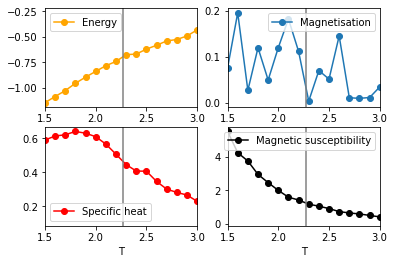

In [282]:
#plotting as a function of temperature
def plot_res(T_list,res):
    fig, axs = plt.subplots(ncols=2, nrows=2)#,layout="constrained")
    axs[0,0].plot(T_list,res[:,0],'o-',c='orange',label='Energy')
    axs[0,1].plot(T_list,np.abs(res[:,1]),'o-',label='Magnetisation')
    axs[1,0].plot(T_list,res[:,2],'o-',c='red',label='Specific heat')
    axs[1,1].plot(T_list,res[:,3],'o-',c='k',label='Magnetic susceptibility')
    for axx in axs:
        for ax in axx:
            ax.legend()
            ax.set_xlabel('T')
            ax.set_xlim([1.5,3])
            ax.axvline(x=2.27,c='grey')
plot_res(T_list,res)
plt.savefig(savepath + "4plots_26_4_obc.pdf", dpi=300, bbox_inches="tight")

>A proper sampling requires more computational time, let's load some results computed with this code for longer runs (10000 steps) and with a more dense sampling of temperatures.

In [ ]:
res = np.loadtxt('./res_acc.txt')
T_list = np.loadtxt('./T_acc.txt')
plot_res(T_list,res)

### Profiling
In the next lecture we will see how to make the code faster by integrating Fortran subroutines into Python code with *f2py*.\
For the moment, we will just investigate where the code spends most of the run time.

In [ ]:
%load_ext line_profiler

In [ ]:
ising = Ising(10,T,100,1000,sample_equi=False)
ising.initialize()
%lprun -f ising.ising_driver ising.ising_driver()

In [ ]:
ising = Ising(10,T,100,1000,sample_equi=False)
ising.initialize()
%lprun -f ising.metro_step ising.ising_driver()

### My stuff

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

data = np.loadtxt('final_config.dat')
x = data[:, 0]
y = data[:, 1]
colors = ['yellow' if i == 1 else 'blue' for i in data[:, 2]]

fig, ax = plt.subplots()
ax.scatter(x, y, c=colors, marker='s', s=50)
ax.set_aspect('equal')

# Create legend
legend_elements = [plt.Line2D([0], [0], marker='s', color='w', label='Spin up', markerfacecolor='yellow', markersize=10),
                   plt.Line2D([0], [0], marker='s', color='w', label='Spin down', markerfacecolor='blue', markersize=10)]
ax.legend(handles=legend_elements)

plt.show()

1.6 0.266 0.243 0.022
1.7 0.329 0.297 0.031
1.8 0.427 0.41 0.017
1.9 0.574 0.498 0.075
2.0 0.754 0.622 0.133
2.1 0.895 0.786 0.109
2.2 1.196 1.138 0.058
2.3 1.764 1.317 0.447
2.4 1.552 1.58 0.028
2.5 0.912 0.95 0.038
2.6 0.728 0.71 0.018
2.7 0.65 0.583 0.067
2.8 0.535 0.455 0.08
2.9 0.437 0.405 0.031
3.0 0.416 0.366 0.049
3.1 0.358 0.356 0.002
3.2 0.28 0.315 0.035
3.3 0.308 0.271 0.036
3.4 0.274 0.242 0.032
3.5 0.22 0.244 0.024
3.6 0.274 0.241 0.033
3.7 0.219 0.207 0.012
3.8 0.215 0.208 0.007
3.9 0.198 0.176 0.022